In [2]:
import argparse
import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
from foolbox import PyTorchModel, accuracy, samples
from foolbox.attacks import LinfPGD, FGSM
from advertorch.attacks import LinfSPSAAttack
from trainers import Trainer, FGSMTrainer
from robustbench.model_zoo.models import Carmon2019UnlabeledNet
from utils import adversarial_accuracy, fgsm_, gradient_norm
import eagerpy as ep
from Nets import CIFAR_Wide_Res_Net, CIFAR_Res_Net, CIFAR_Net
%load_ext autoreload
%autoreload 2
%aimport Nets, trainers

In [3]:
# setup
device = torch.device("cuda")
batch_size = 128
# remove the normalize
transform = transform = transforms.Compose(
            [transforms.ToTensor()]
)
        
normalized_min = (0 - 0.5) / 0.5
normalized_max = (1 - 0.5) / 0.5
train_dataset = datasets.CIFAR10(root='./data', train=True,
                                download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                  shuffle=True, num_workers=2)
test_dataset = datasets.CIFAR10(root='./data', train=False,
                               download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                 shuffle=False, num_workers=2)
classes = classes = ('plane', 'car', 'bird', 'cat',
   'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Load Regular CIFAR-10 model

In [4]:
model = CIFAR_Res_Net(device).eval()
model.load_state_dict(torch.load("models/cifar_res_net.model"))

<All keys matched successfully>

## Load CIFAR-10 Model trained with large FGSM steps

In [5]:
fgsm_model = CIFAR_Res_Net(device).eval()
fgsm_model.load_state_dict(torch.load("models/cifar_res_net_fgsm06.model"))

<All keys matched successfully>

### Check gradient norms
Gradients seem to blow up after FGSM training

In [6]:
subset_size = 5000
subset = torch.utils.data.Subset(train_dataset, np.random.randint(0, len(test_dataset), size=subset_size).tolist())
subset_loader = torch.utils.data.DataLoader(subset, batch_size=batch_size,
                                 shuffle=False, num_workers=2)

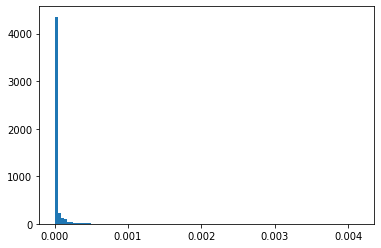

In [7]:
plt.hist(gradient_norm(model, subset_loader, device=device).detach().cpu().numpy(), bins=100)
plt.show()

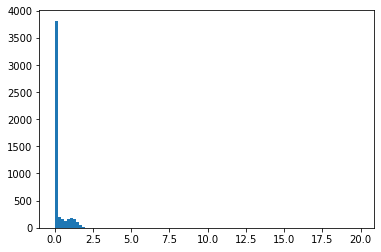

In [8]:
plt.hist(gradient_norm(fgsm_model, subset_loader, device=device).detach().cpu().numpy(), bins=100)
plt.show()